In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =20

nref =3

p_refs = (/ 1 , 50 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

ng_refs = (/ 5 , 5 , 10 /) 

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

klin =5e-25

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

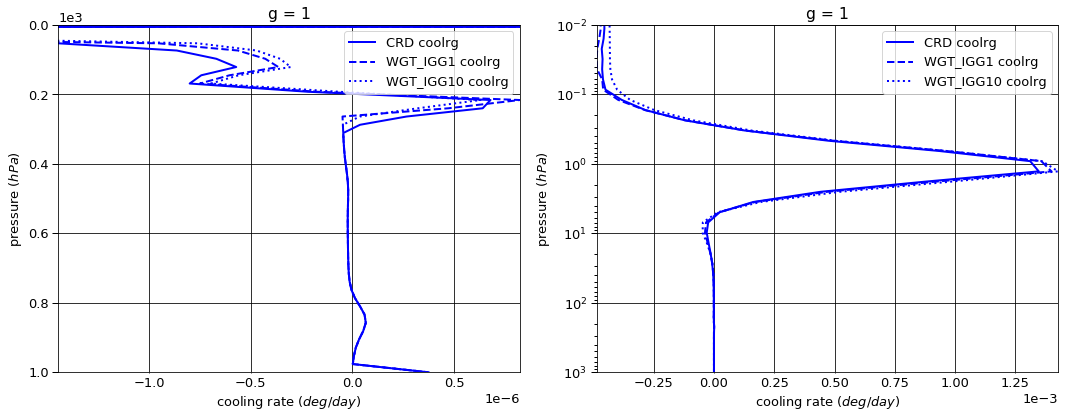

# Figure: cooling rate g-group 2

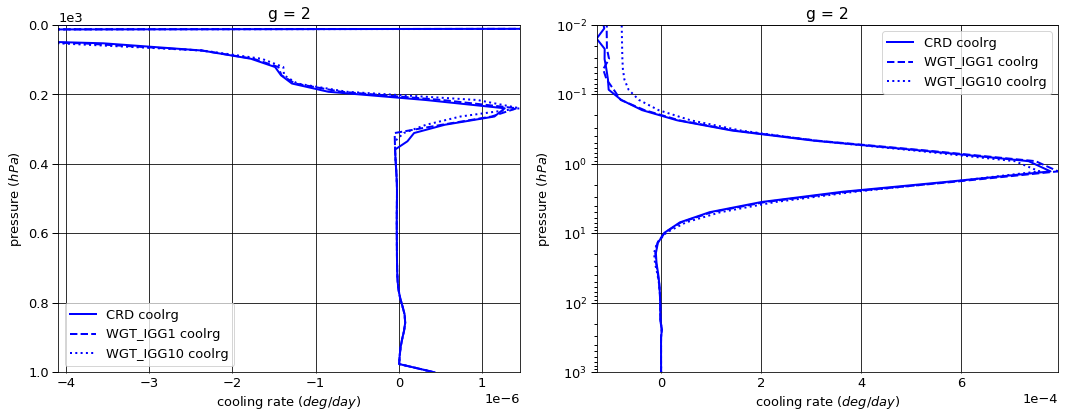

# Figure: cooling rate g-group 3

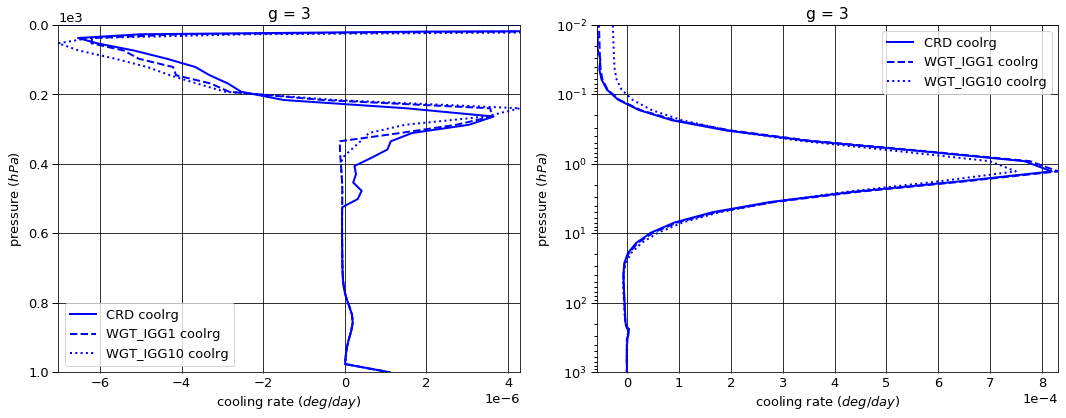

# Figure: cooling rate g-group 4

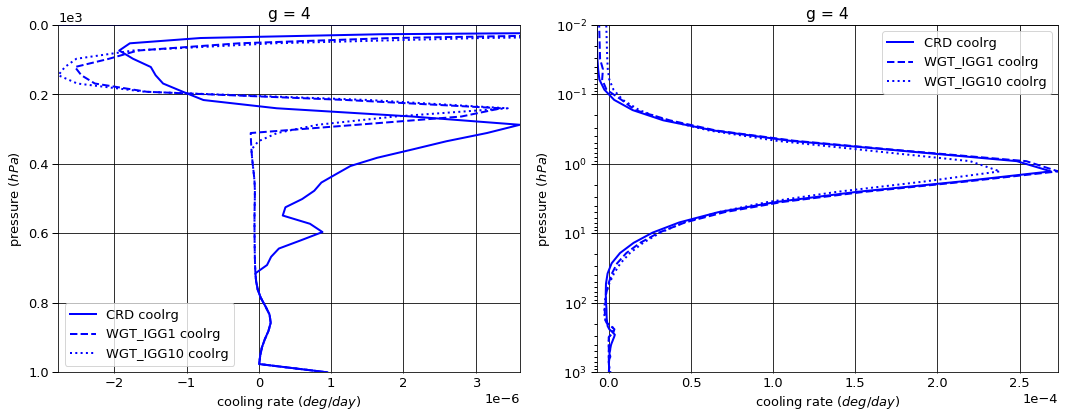

# Figure: cooling rate g-group 5

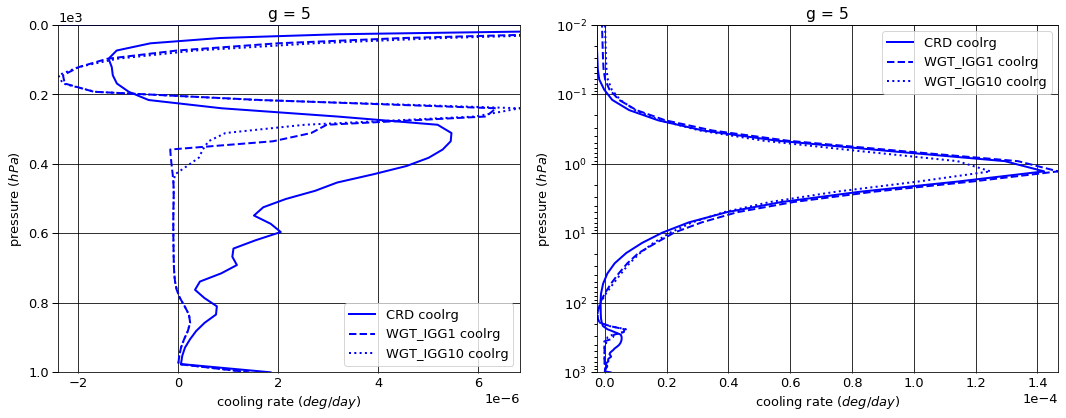

# Figure: cooling rate g-group 6

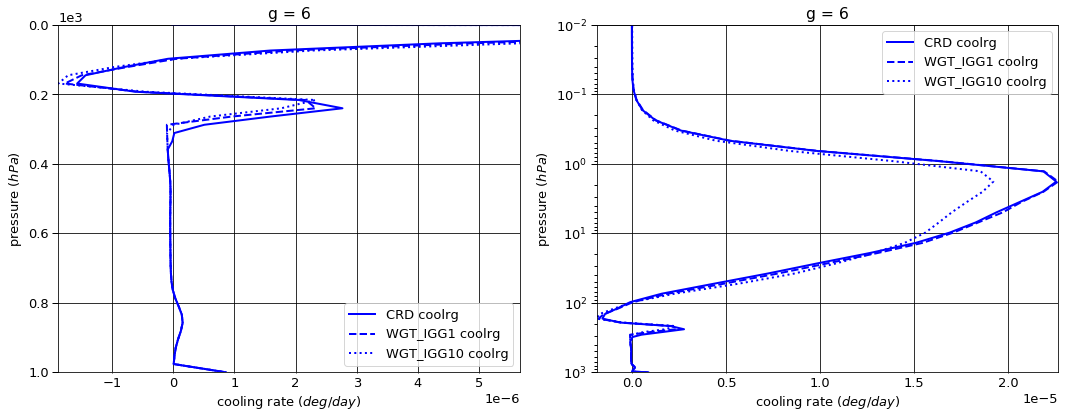

# Figure: cooling rate g-group 7

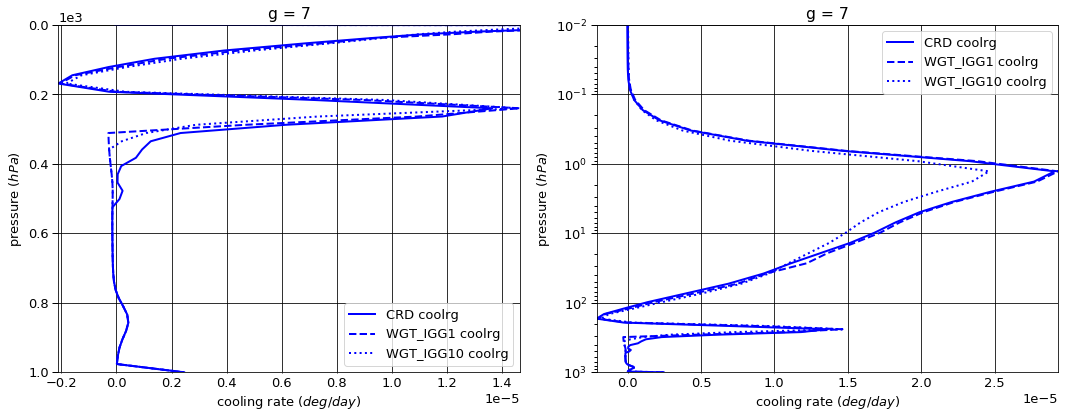

# Figure: cooling rate g-group 8

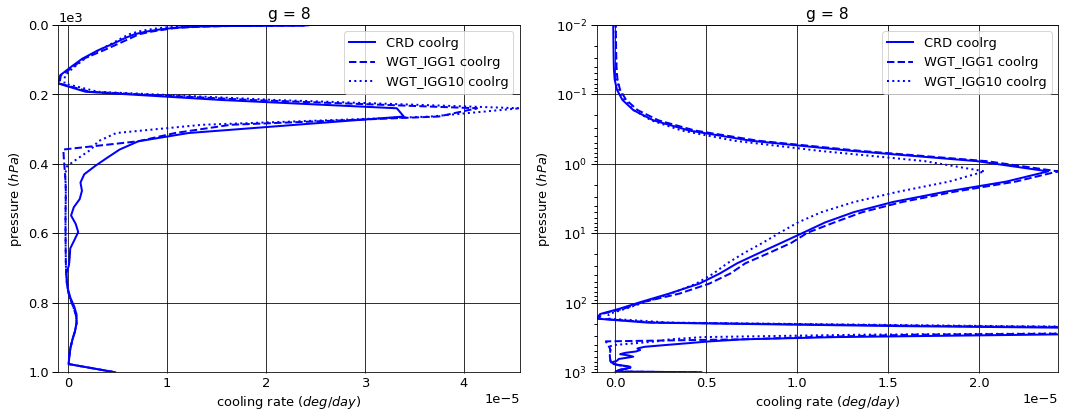

# Figure: cooling rate g-group 9

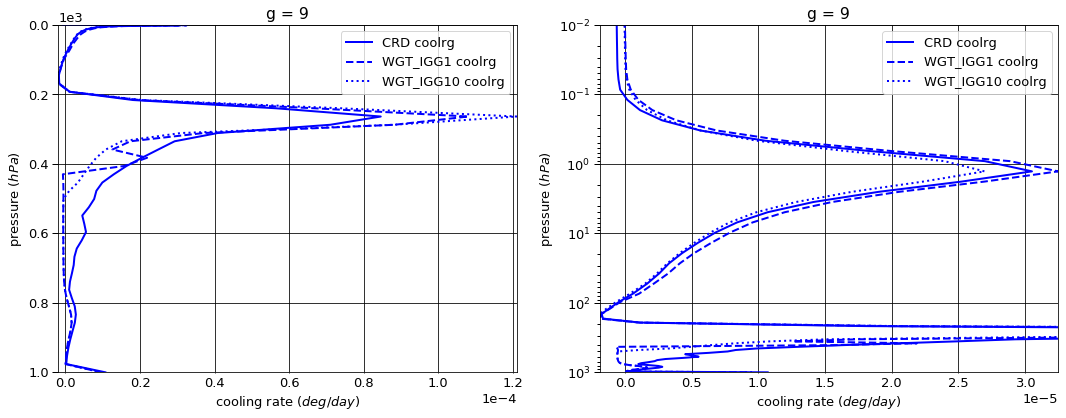

# Figure: cooling rate g-group 10

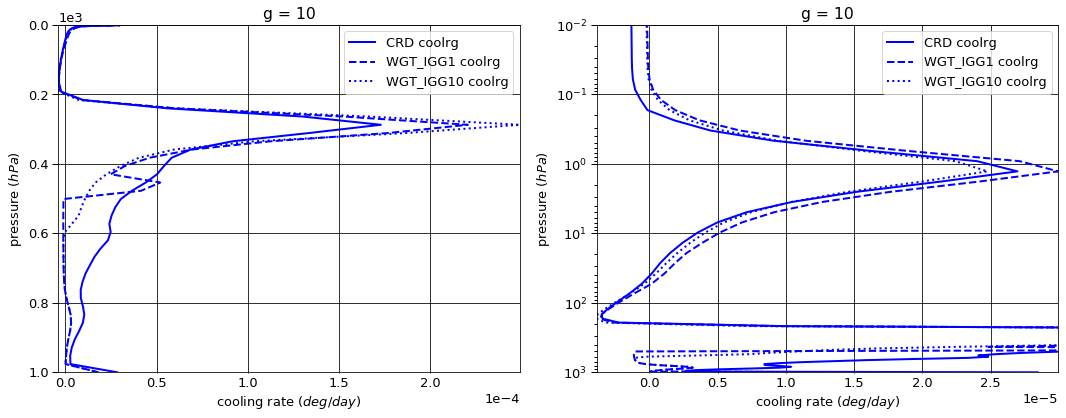

# Figure: cooling rate g-group 11

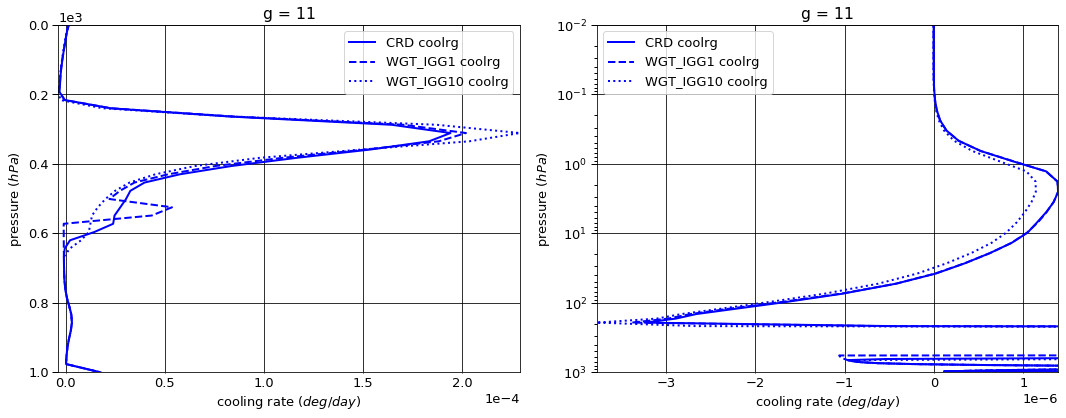

# Figure: cooling rate g-group 12

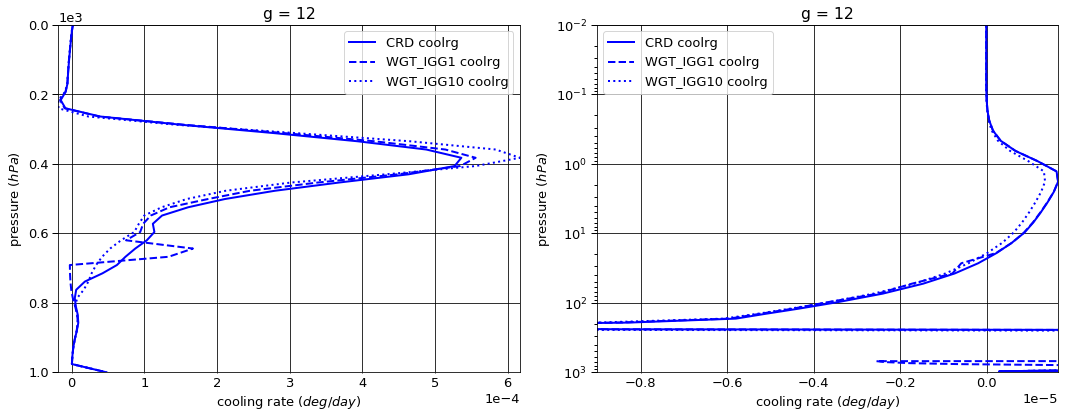

# Figure: cooling rate g-group 13

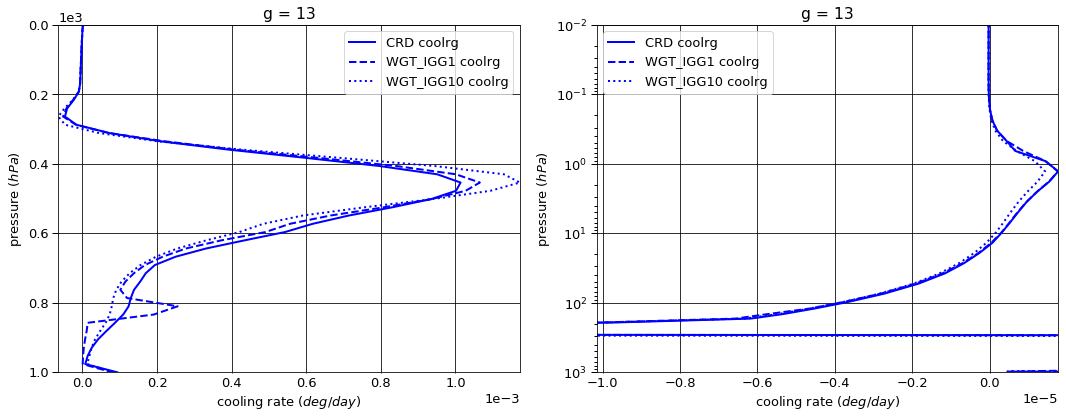

# Figure: cooling rate g-group 14

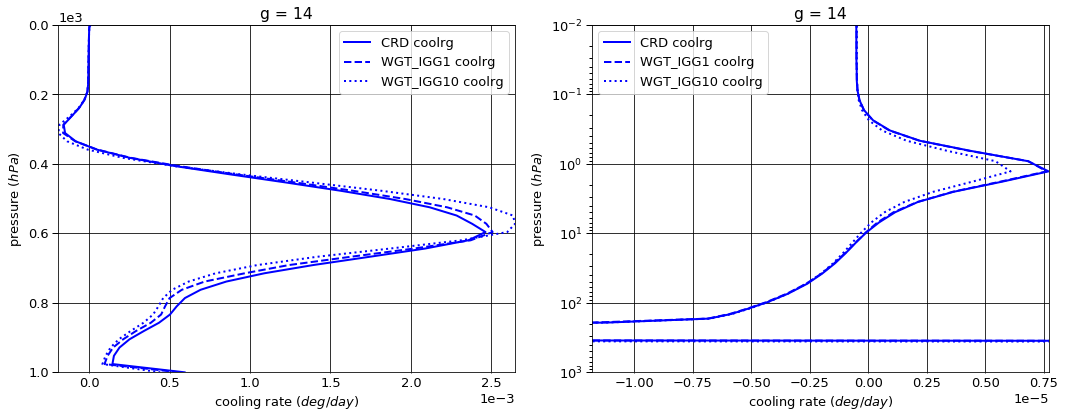

# Figure: cooling rate g-group 15

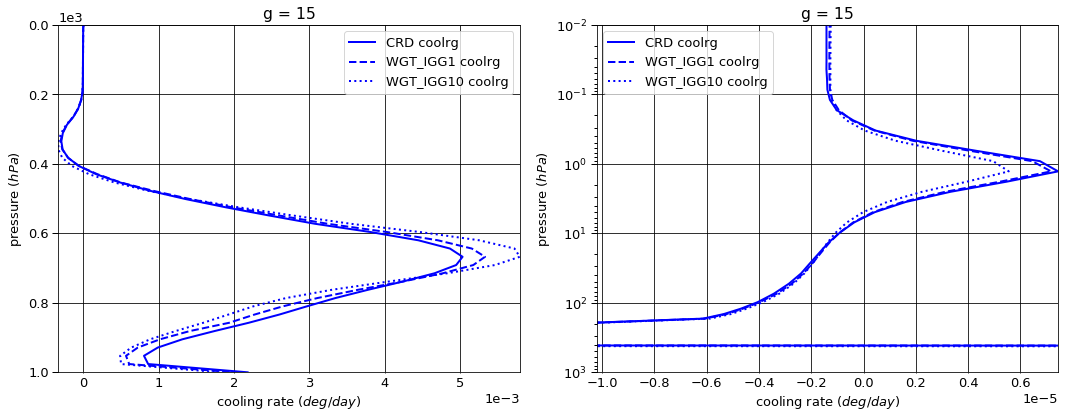

# Figure: cooling rate g-group 16

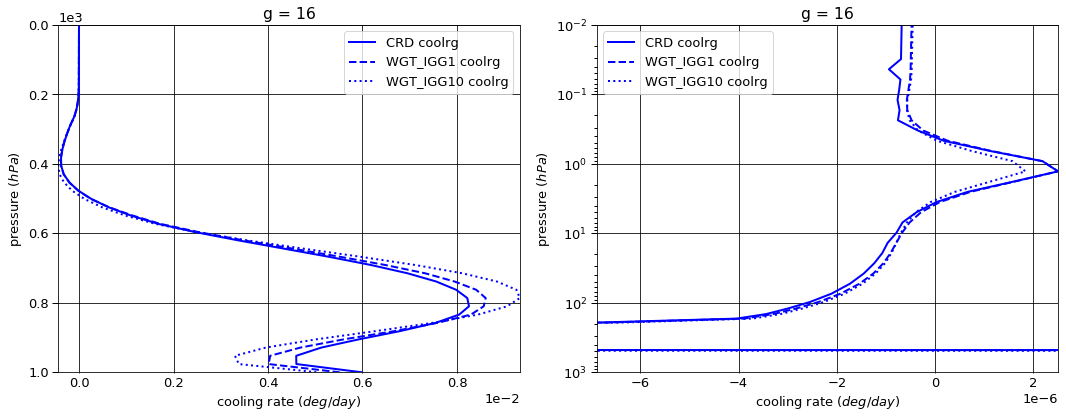

# Figure: cooling rate g-group 17

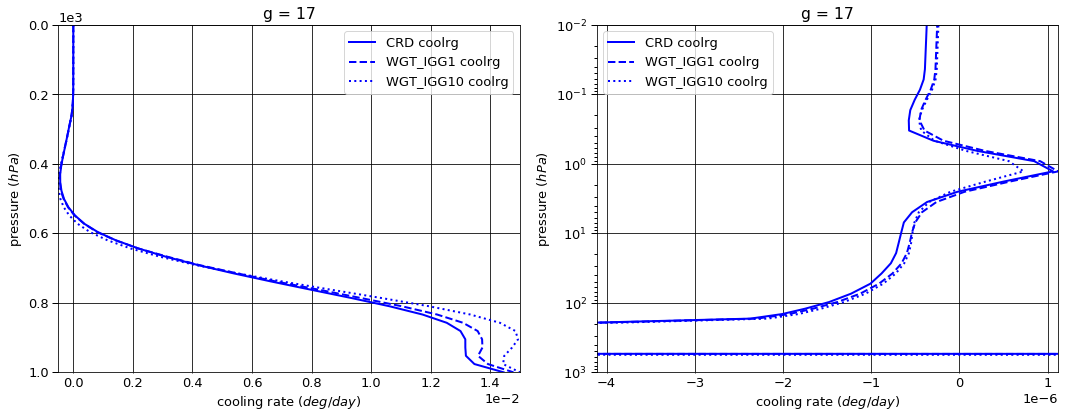

# Figure: cooling rate g-group 18

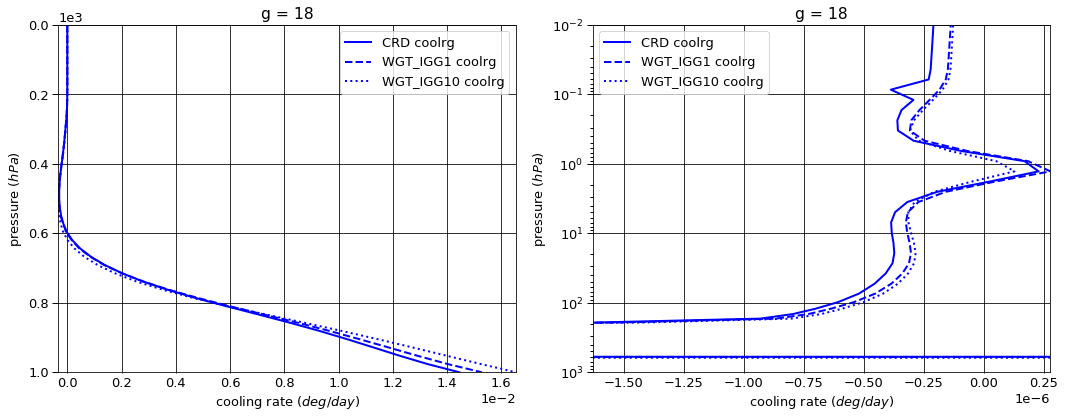

# Figure: cooling rate g-group 19

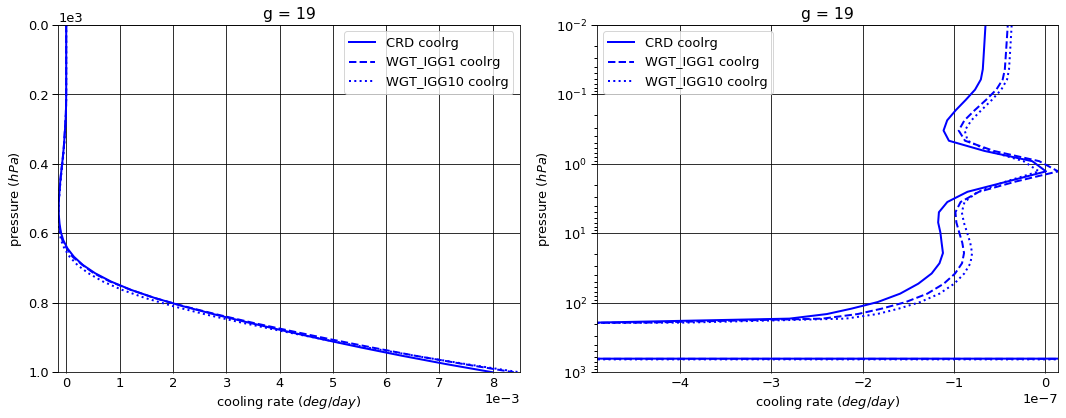

# Figure: cooling rate g-group 20

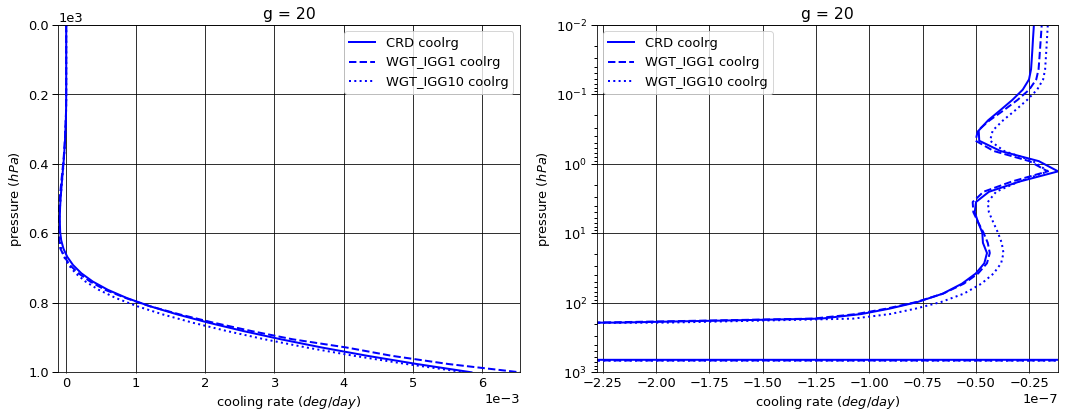

# Figure: cooling rate g-group total

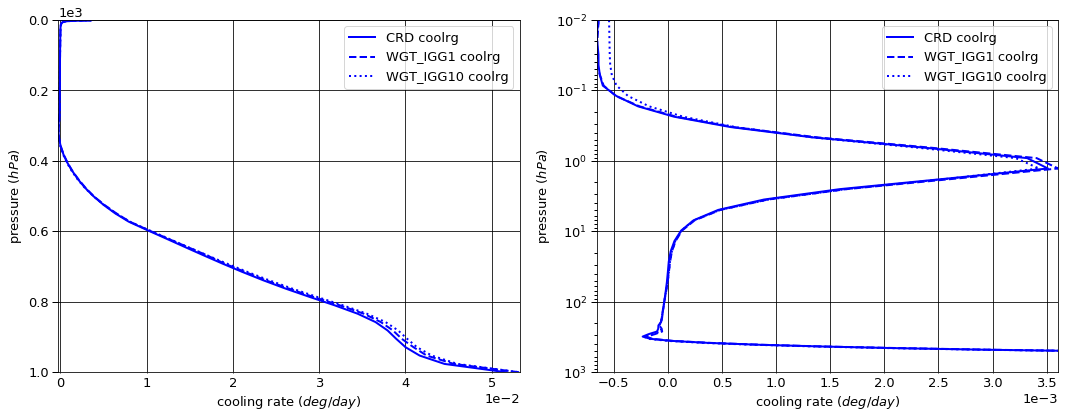

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000213  0.000000 -0.000213
   1013.0   76    -0.000744  0.000743 -0.000001
2  0.0      1     -0.000173  0.000000 -0.000173
   1013.0   76    -0.000847  0.000846 -0.000001
3  0.0      1     -0.000262  0.000000 -0.000262
   1013.0   76    -0.002150  0.002146 -0.000003
4  0.0      1     -0.000167  0.000000 -0.000167
   1013.0   76    -0.001825  0.001822 -0.000003
5  0.0      1     -0.000247  0.000000 -0.000247
   1013.0   76    -0.002712  0.002707 -0.000005
6  0.0      1     -0.000088  0.000000 -0.000088
   1013.0   76    -0.001706  0.001704 -0.000002
7  0.0      1     -0.000229  0.000000 -0.000229
   1013.0   76    -0.004839  0.004832 -0.000007
8  0.0      1     -0.000514  0.000000 -0.000514
   1013.0   76    -0.009296  0.009283 -0.000013
9  0.0      1     -0.001358  0.000000 -0.001358
   1013.0   76    -0.018545  0.018515 -0.000030
10 0.0      1     -0.003508  0.000000 -0.003508
   1013.0   76    -0.035401  0.035319 -0.000083
11 0.0      1     -0.003621  0.000000 -0.003621
   1013.0   76    -0.034450  0.034401 -0.000049
12 0.0      1     -0.013303  0.000000 -0.013303
   1013.0   76    -0.093647  0.093513 -0.000135
13 0.0      1     -0.030883  0.000000 -0.030883
   1013.0   76    -0.154585  0.154329 -0.000256
14 0.0      1     -0.083020  0.000000 -0.083020
   1013.0   76    -0.288474  0.286902 -0.001571
15 0.0      1     -0.186411  0.000000 -0.186411
   1013.0   76    -0.460754  0.453251 -0.007502
16 0.0      1     -0.344797  0.000000 -0.344797
   1013.0   76    -0.627231  0.593130 -0.034100
17 0.0      1     -0.602682  0.000000 -0.602682
   1013.0   76    -0.851332  0.680433 -0.170899
18 0.0      1     -0.688219  0.000000 -0.688219
   1013.0   76    -0.818886  0.428054 -0.390832
19 0.0      1     -0.654059  0.000000 -0.654059
   1013.0   76    -0.704873  0.185157 -0.519716
20 0.0      1     -2.483385  0.000000 -2.483385
   1013.0   76    -2.513155  0.116414 -2.396741


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000221  0.000000 -0.000221
   1013.0   76    -0.000744  0.000743 -0.000001
2  0.0      1     -0.000176  0.000000 -0.000176
   1013.0   76    -0.000847  0.000846 -0.000001
3  0.0      1     -0.000259  0.000000 -0.000259
   1013.0   76    -0.002150  0.002146 -0.000003
4  0.0      1     -0.000135  0.000000 -0.000135
   1013.0   76    -0.001825  0.001822 -0.000003
5  0.0      1     -0.000145  0.000000 -0.000145
   1013.0   76    -0.002712  0.002708 -0.000004
6  0.0      1     -0.000087  0.000000 -0.000087
   1013.0   76    -0.001706  0.001704 -0.000002
7  0.0      1     -0.000217  0.000000 -0.000217
   1013.0   76    -0.004839  0.004832 -0.000007
8  0.0      1     -0.000469  0.000000 -0.000469
   1013.0   76    -0.009296  0.009283 -0.000013
9  0.0      1     -0.001174  0.000000 -0.001174
   1013.0   76    -0.018545  0.018518 -0.000027
10 0.0      1     -0.002901  0.000000 -0.002901
   1013.0   76    -0.035401  0.035350 -0.000051
11 0.0      1     -0.003562  0.000000 -0.003562
   1013.0   76    -0.034450  0.034401 -0.000049
12 0.0      1     -0.012977  0.000000 -0.012977
   1013.0   76    -0.093647  0.093513 -0.000135
13 0.0      1     -0.030110  0.000000 -0.030110
   1013.0   76    -0.154585  0.154362 -0.000223
14 0.0      1     -0.081238  0.000000 -0.081238
   1013.0   76    -0.288474  0.287013 -0.001460
15 0.0      1     -0.182153  0.000000 -0.182153
   1013.0   76    -0.460754  0.454832 -0.005922
16 0.0      1     -0.338129  0.000000 -0.338129
   1013.0   76    -0.627231  0.601686 -0.025544
17 0.0      1     -0.595896  0.000000 -0.595896
   1013.0   76    -0.851332  0.701866 -0.149466
18 0.0      1     -0.684320  0.000000 -0.684320
   1013.0   76    -0.818886  0.443668 -0.375218
19 0.0      1     -0.652430  0.000000 -0.652430
   1013.0   76    -0.704873  0.190769 -0.514104
20 0.0      1     -2.480491  0.000000 -2.480491
   1013.0   76    -2.513155  0.124440 -2.388716


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000230  0.000000 -0.000230
   1013.0   76    -0.000744  0.000743 -0.000001
2  0.0      1     -0.000178  0.000000 -0.000178
   1013.0   76    -0.000847  0.000846 -0.000001
3  0.0      1     -0.000251  0.000000 -0.000251
   1013.0   76    -0.002150  0.002146 -0.000003
4  0.0      1     -0.000128  0.000000 -0.000128
   1013.0   76    -0.001825  0.001822 -0.000003
5  0.0      1     -0.000137  0.000000 -0.000137
   1013.0   76    -0.002712  0.002708 -0.000004
6  0.0      1     -0.000085  0.000000 -0.000085
   1013.0   76    -0.001706  0.001704 -0.000002
7  0.0      1     -0.000209  0.000000 -0.000209
   1013.0   76    -0.004839  0.004832 -0.000007
8  0.0      1     -0.000458  0.000000 -0.000458
   1013.0   76    -0.009296  0.009283 -0.000013
9  0.0      1     -0.001159  0.000000 -0.001159
   1013.0   76    -0.018545  0.018518 -0.000027
10 0.0      1     -0.002867  0.000000 -0.002867
   1013.0   76    -0.035401  0.035350 -0.000051
11 0.0      1     -0.003516  0.000000 -0.003516
   1013.0   76    -0.034450  0.034401 -0.000049
12 0.0      1     -0.012776  0.000000 -0.012776
   1013.0   76    -0.093647  0.093513 -0.000135
13 0.0      1     -0.029642  0.000000 -0.029642
   1013.0   76    -0.154585  0.154362 -0.000223
14 0.0      1     -0.080100  0.000000 -0.080100
   1013.0   76    -0.288474  0.287332 -0.001142
15 0.0      1     -0.180109  0.000000 -0.180109
   1013.0   76    -0.460754  0.455672 -0.005081
16 0.0      1     -0.335243  0.000000 -0.335243
   1013.0   76    -0.627231  0.606178 -0.021053
17 0.0      1     -0.595211  0.000000 -0.595211
   1013.0   76    -0.851332  0.724231 -0.127101
18 0.0      1     -0.688874  0.000000 -0.688874
   1013.0   76    -0.818886  0.450028 -0.368858
19 0.0      1     -0.656888  0.000000 -0.656888
   1013.0   76    -0.704873  0.181699 -0.523174
20 0.0      1     -2.485245  0.000000 -2.485245
   1013.0   76    -2.513155  0.107744 -2.405411


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1     -7.508260e-06  0.000000 -7.508260e-06
   1013.0   76     0.000000e+00  0.000000  2.117582e-22
2  0.0      1     -3.542210e-06  0.000000 -3.542210e-06
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1      2.294550e-06  0.000000  2.294550e-06
   1013.0   76     0.000000e+00  0.000000 -4.235165e-22
4  0.0      1      3.188273e-05  0.000000  3.188273e-05
   1013.0   76     2.168404e-19  0.000000  0.000000e+00
5  0.0      1      1.022255e-04  0.000000  1.022255e-04
   1013.0   76     0.000000e+00  0.000001  1.154852e-06
6  0.0      1      8.871840e-07  0.000000  8.871840e-07
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      1.179246e-05  0.000000  1.179246e-05
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
8  0.0      1      4.576908e-05  0.000000  4.576908e-05
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
9  0.0      1      1.833316e-04  0.000000  1.833316e-04
   1013.0   76     0.000000e+00  0.000003  3.202001e-06
10 0.0      1      6.069676e-04  0.000000  6.069676e-04
   1013.0   76     0.000000e+00  0.000031  3.149765e-05
11 0.0      1      5.919040e-05  0.000000  5.919040e-05
   1013.0   76    -6.938894e-18  0.000000 -6.776264e-21
12 0.0      1      3.262010e-04  0.000000  3.262010e-04
   1013.0   76     1.387779e-17  0.000000  0.000000e+00
13 0.0      1      7.725320e-04  0.000000  7.725320e-04
   1013.0   76     0.000000e+00  0.000033  3.306383e-05
14 0.0      1      1.782670e-03  0.000000  1.782670e-03
   1013.0   76     0.000000e+00  0.000111  1.111037e-04
15 0.0      1      4.258050e-03  0.000000  4.258050e-03
   1013.0   76     0.000000e+00  0.001581  1.580584e-03
16 0.0      1      6.668110e-03  0.000000  6.668110e-03
   1013.0   76     0.000000e+00  0.008556  8.555952e-03
17 0.0      1      6.785190e-03  0.000000  6.785190e-03
   1013.0   76     0.000000e+00  0.021434  2.143377e-02
18 0.0      1      3.899140e-03  0.000000  3.899140e-03
   1013.0   76     0.000000e+00  0.015614  1.561377e-02
19 0.0      1      1.629520e-03  0.000000  1.629520e-03
   1013.0   76     0.000000e+00  0.005612  5.612390e-03
20 0.0      1      2.894100e-03  0.000000  2.894100e-03
   1013.0   76     0.000000e+00  0.008026  8.025800e-03


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1     -1.657696e-05  0.000000 -1.657696e-05
   1013.0   76     0.000000e+00  0.000000  2.117582e-22
2  0.0      1     -5.216530e-06  0.000000 -5.216530e-06
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1      1.060811e-05  0.000000  1.060811e-05
   1013.0   76     0.000000e+00  0.000000 -4.235165e-22
4  0.0      1      3.846224e-05  0.000000  3.846224e-05
   1013.0   76     2.168404e-19  0.000000  0.000000e+00
5  0.0      1      1.104099e-04  0.000000  1.104099e-04
   1013.0   76     0.000000e+00  0.000001  1.154852e-06
6  0.0      1      3.120361e-06  0.000000  3.120361e-06
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      1.997909e-05  0.000000  1.997909e-05
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
8  0.0      1      5.681605e-05  0.000000  5.681605e-05
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
9  0.0      1      1.989252e-04  0.000000  1.989252e-04
   1013.0   76     0.000000e+00  0.000003  3.202001e-06
10 0.0      1      6.412592e-04  0.000000  6.412592e-04
   1013.0   76     0.000000e+00  0.000031  3.149765e-05
11 0.0      1      1.053163e-04  0.000000  1.053163e-04
   1013.0   76    -6.938894e-18  0.000000 -6.776264e-21
12 0.0      1      5.276690e-04  0.000000  5.276690e-04
   1013.0   76     1.387779e-17  0.000000  0.000000e+00
13 0.0      1      1.240782e-03  0.000000  1.240782e-03
   1013.0   76     0.000000e+00  0.000033  3.306380e-05
14 0.0      1      2.920459e-03  0.000000  2.920459e-03
   1013.0   76     0.000000e+00  0.000429  4.291807e-04
15 0.0      1      6.302270e-03  0.000000  6.302270e-03
   1013.0   76     0.000000e+00  0.002421  2.421008e-03
16 0.0      1      9.553800e-03  0.000000  9.553800e-03
   1013.0   76     0.000000e+00  0.013048  1.304772e-02
17 0.0      1      7.470680e-03  0.000000  7.470680e-03
   1013.0   76     0.000000e+00  0.043798  4.379826e-02
18 0.0      1     -6.553400e-04  0.000000 -6.553400e-04
   1013.0   76     0.000000e+00  0.021974  2.197398e-02
19 0.0      1     -2.829140e-03  0.000000 -2.829140e-03
   1013.0   76     0.000000e+00 -0.003457 -3.457380e-03
20 0.0      1     -1.860200e-03  0.000000 -1.860200e-03
   1013.0   76     0.000000e+00 -0.008670 -8.669700e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.918181e-04
   1001.112500 75     3.751916e-07
2  0.000312    1     -1.100043e-04
   1001.112500 75     4.274485e-07
3  0.000312    1     -5.915048e-05
   1001.112500 75     1.103291e-06
4  0.000312    1     -8.316892e-06
   1001.112500 75     9.461010e-07
5  0.000312    1     -3.139193e-06
   1001.112500 75     1.848909e-06
6  0.000312    1     -1.849167e-08
   1001.112500 75     8.601953e-07
7  0.000312    1     -4.787617e-08
   1001.112500 75     2.457705e-06
8  0.000312    1     -1.411350e-07
   1001.112500 75     4.735137e-06
9  0.000312    1     -6.872260e-07
   1001.112500 75     1.070176e-05
10 0.000312    1     -1.345103e-06
   1001.112500 75     2.846042e-05
11 0.000312    1     -4.810467e-09
   1001.112500 75     1.748372e-05
12 0.000312    1     -5.921285e-09
   1001.112500 75     4.783879e-05
13 0.000312    1     -2.194846e-08
   1001.112500 75     9.334248e-05
14 0.000312    1     -5.140012e-07
   1001.112500 75     5.927646e-04
15 0.000312    1     -1.405058e-06
   1001.112500 75     2.179714e-03
16 0.000312    1     -6.478263e-07
   1001.112500 75     5.988960e-03
17 0.000312    1     -3.351775e-07
   1001.112500 75     1.444655e-02
18 0.000312    1     -1.894076e-07
   1001.112500 75     1.445201e-02
19 0.000312    1     -6.048206e-08
   1001.112500 75     7.999505e-03
20 0.000312    1     -2.093021e-08
   1001.112500 75     5.844999e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -4.762644e-04
   1001.112500 75     3.751916e-07
2  0.000312    1     -1.090475e-04
   1001.112500 75     4.274485e-07
3  0.000312    1     -5.706505e-05
   1001.112500 75     1.103291e-06
4  0.000312    1     -6.840837e-06
   1001.112500 75     9.461010e-07
5  0.000312    1     -1.481125e-06
   1001.112500 75     1.423228e-06
6  0.000312    1     -1.349640e-08
   1001.112500 75     8.601953e-07
7  0.000312    1     -1.052878e-08
   1001.112500 75     2.457705e-06
8  0.000312    1     -1.685831e-08
   1001.112500 75     4.735137e-06
9  0.000312    1     -1.212830e-07
   1001.112500 75     9.520585e-06
10 0.000312    1     -2.751074e-07
   1001.112500 75     1.819960e-05
11 0.000312    1     -5.540501e-09
   1001.112500 75     1.748372e-05
12 0.000312    1     -5.221060e-09
   1001.112500 75     4.783879e-05
13 0.000312    1     -2.199781e-08
   1001.112500 75     7.920551e-05
14 0.000312    1     -5.020297e-07
   1001.112500 75     5.567883e-04
15 0.000312    1     -1.267073e-06
   1001.112500 75     1.996954e-03
16 0.000312    1     -4.416185e-07
   1001.112500 75     5.517012e-03
17 0.000312    1     -2.189536e-07
   1001.112500 75     1.477525e-02
18 0.000312    1     -1.167538e-07
   1001.112500 75     1.528285e-02
19 0.000312    1     -3.569123e-08
   1001.112500 75     8.396444e-03
20 0.000312    1     -1.679340e-08
   1001.112500 75     6.542941e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -4.365101e-04
   1001.112500 75     3.751916e-07
2  0.000312    1     -8.020452e-05
   1001.112500 75     4.274485e-07
3  0.000312    1     -3.091302e-05
   1001.112500 75     1.103291e-06
4  0.000312    1     -2.643172e-06
   1001.112500 75     9.461010e-07
5  0.000312    1     -4.623131e-07
   1001.112500 75     1.423228e-06
6  0.000312    1     -2.721638e-09
   1001.112500 75     8.601953e-07
7  0.000312    1      2.633832e-09
   1001.112500 75     2.457705e-06
8  0.000312    1     -1.463798e-08
   1001.112500 75     4.735137e-06
9  0.000312    1     -1.320640e-07
   1001.112500 75     9.520585e-06
10 0.000312    1     -2.873272e-07
   1001.112500 75     1.819960e-05
11 0.000312    1     -5.568874e-09
   1001.112500 75     1.748372e-05
12 0.000312    1     -5.154499e-09
   1001.112500 75     4.783879e-05
13 0.000312    1     -2.146720e-08
   1001.112500 75     8.348921e-05
14 0.000312    1     -4.867163e-07
   1001.112500 75     4.411955e-04
15 0.000312    1     -1.216840e-06
   1001.112500 75     1.805584e-03
16 0.000312    1     -4.191460e-07
   1001.112500 75     5.047356e-03
17 0.000312    1     -2.061860e-07
   1001.112500 75     1.498982e-02
18 0.000312    1     -1.079263e-07
   1001.112500 75     1.653891e-02
19 0.000312    1     -3.194919e-08
   1001.112500 75     8.506786e-03
20 0.000312    1     -1.430171e-08
   1001.112500 75     5.749192e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.555378e-05
   1001.112500 75     0.000000e+00
2  0.000312    1      9.568100e-07
   1001.112500 75     0.000000e+00
3  0.000312    1      2.085433e-06
   1001.112500 75     0.000000e+00
4  0.000312    1      1.476055e-06
   1001.112500 75     0.000000e+00
5  0.000312    1      1.658068e-06
   1001.112500 75    -4.256810e-07
6  0.000312    1      4.995266e-09
   1001.112500 75     0.000000e+00
7  0.000312    1      3.734739e-08
   1001.112500 75     0.000000e+00
8  0.000312    1      1.242767e-07
   1001.112500 75     0.000000e+00
9  0.000312    1      5.659429e-07
   1001.112500 75    -1.181174e-06
10 0.000312    1      1.069995e-06
   1001.112500 75    -1.026082e-05
11 0.000312    1     -7.300347e-10
   1001.112500 75     0.000000e+00
12 0.000312    1      7.002254e-10
   1001.112500 75     0.000000e+00
13 0.000312    1     -4.934600e-11
   1001.112500 75    -1.413697e-05
14 0.000312    1      1.197156e-08
   1001.112500 75    -3.597636e-05
15 0.000312    1      1.379849e-07
   1001.112500 75    -1.827608e-04
16 0.000312    1      2.062077e-07
   1001.112500 75    -4.719480e-04
17 0.000312    1      1.162239e-07
   1001.112500 75     3.286990e-04
18 0.000312    1      7.265382e-08
   1001.112500 75     8.308390e-04
19 0.000312    1      2.479083e-08
   1001.112500 75     3.969388e-04
20 0.000312    1      4.136808e-09
   1001.112500 75     6.979417e-04


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      5.530804e-05
   1001.112500 75     0.000000e+00
2  0.000312    1      2.979983e-05
   1001.112500 75     0.000000e+00
3  0.000312    1      2.823746e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      5.673720e-06
   1001.112500 75     0.000000e+00
5  0.000312    1      2.676880e-06
   1001.112500 75    -4.256810e-07
6  0.000312    1      1.577003e-08
   1001.112500 75     0.000000e+00
7  0.000312    1      5.051000e-08
   1001.112500 75     0.000000e+00
8  0.000312    1      1.264970e-07
   1001.112500 75     0.000000e+00
9  0.000312    1      5.551619e-07
   1001.112500 75    -1.181174e-06
10 0.000312    1      1.057775e-06
   1001.112500 75    -1.026082e-05
11 0.000312    1     -7.584075e-10
   1001.112500 75     0.000000e+00
12 0.000312    1      7.667862e-10
   1001.112500 75     0.000000e+00
13 0.000312    1      4.812640e-10
   1001.112500 75    -9.853275e-06
14 0.000312    1      2.728496e-08
   1001.112500 75    -1.515691e-04
15 0.000312    1      1.882187e-07
   1001.112500 75    -3.741302e-04
16 0.000312    1      2.286802e-07
   1001.112500 75    -9.416044e-04
17 0.000312    1      1.289916e-07
   1001.112500 75     5.432700e-04
18 0.000312    1      8.148131e-08
   1001.112500 75     2.086896e-03
19 0.000312    1      2.853287e-08
   1001.112500 75     5.072807e-04
20 0.000312    1      6.628499e-09
   1001.112500 75    -9.580710e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.097139,0.0000,-5.097139
1013.0,76,-6.625452,3.1035,-3.521952



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.067091,0.000000,-5.067091
1013.0,76,-6.625452,3.164502,-3.460950



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.073305,0.000000,-5.073305
1013.0,76,-6.625452,3.173112,-3.452340



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.030049,0.000000,0.030049
1013.0,76,0.000000,0.061002,0.061002



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.023834,0.000000,0.023834
1013.0,76,0.000000,0.069612,0.069612


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000678
1001.112500,75,0.051715



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000654
1001.112500,75,0.053253



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000554
1001.112500,75,0.053268



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000024
1001.112500,75,0.001538



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000124
1001.112500,75,0.001553


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000032,0.000134
2,0.000036,0.000153
3,0.000105,0.000376
4,0.000095,0.000314
5,0.000200,0.000458
6,0.000073,0.000308
7,0.000218,0.000863
8,0.000432,0.001649
9,0.001023,0.003249


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,9.212187e-19
2,2.926488e-19
3,9.296744e-20
4,2.953350e-20
5,9.382076e-21
6,6.284913e-20
7,2.133681e-20
8,7.243691e-21
9,2.459180e-21


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,9.212187e-19,NaN,0.000032,0.000134,0.000032,0.000134,1.0
2,2.926488e-19,0.317676,0.000036,0.000153,0.000068,0.000287,1.0
3,9.296744e-20,0.317676,0.000105,0.000376,0.000173,0.000663,1.0
4,2.953350e-20,0.317676,0.000095,0.000314,0.000268,0.000977,1.0
5,9.382076e-21,0.317676,0.000200,0.000458,0.000468,0.001435,1.0
6,6.284913e-20,6.698850,0.000073,0.000308,0.000541,0.001743,50.0
7,2.133681e-20,0.339493,0.000218,0.000863,0.000759,0.002605,50.0
8,7.243691e-21,0.339493,0.000432,0.001649,0.001191,0.004255,50.0
9,2.459180e-21,0.339493,0.001023,0.003249,0.002214,0.007504,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g  pressure                                                         
1     1  0.000312     1.166815e-18  1.037980e-18    1.124121  9.936730e-05
      2  0.000312     3.007667e-19  2.834813e-19    1.060976  2.561364e-05
      3  0.000312     1.015998e-19  9.204623e-20    1.103791  8.652358e-06
      4  0.000312     2.605463e-20  2.272465e-20    1.146536  2.218842e-06
      5  0.000312     8.323112e-21  6.537378e-21    1.273158  7.088057e-07
      6  0.000312     2.067491e-22  2.057899e-22    1.004661  1.760699e-08
      7  0.000312     1.995508e-22  1.944498e-22    1.026233  1.699397e-08
      8  0.000312     1.598819e-22  1.371344e-22    1.165878  1.361573e-08
      9  0.000312     1.908254e-22  1.072474e-22    1.779300  1.625091e-08
      10 0.000312     1.112342e-22  5.296762e-23    2.100041  9.472829e-09
      11 0.000312     1.473880e-24  1.393552e-24    1.057643  1.255173e-10
      12 0.000312     3.103285e-25  2.937942e-25    1.056278  2.642793e-11
      13 0.000312     4.891966e-25  4.182889e-25    1.169519  4.166054e-11
      14 0.000312     3.764101e-24  9.029704e-25    4.168576  3.205551e-10
      15 0.000312     3.965659e-24  5.241992e-25    7.565175  3.377201e-10
      16 0.000312     7.087789e-25  1.334811e-25    5.309956  6.036042e-11
      17 0.000312     1.919456e-25  5.059473e-26    3.793786  1.634631e-11
      18 0.000312     8.546104e-26  2.235188e-26    3.823439  7.277960e-12
      19 0.000312     2.627243e-26  6.554315e-27    4.008417  2.237390e-12
      20 0.000312     3.078408e-27  4.455014e-30  690.998400  2.621607e-13
2     1  0.000750     1.169658e-18  1.040410e-18    1.124228  4.012135e-05
      2  0.000750     3.019195e-19  2.845153e-19    1.061171  1.035638e-05
      3  0.000750     1.019449e-19  9.237786e-20    1.103564  3.496891e-06
      4  0.000750     2.618064e-20  2.284426e-20    1.146049  8.980423e-07
      5  0.000750     8.359403e-21  6.573106e-21    1.271758  2.867423e-07
      6  0.000750     2.099029e-22  2.088195e-22    1.005188  7.200041e-09
      7  0.000750     2.017485e-22  1.965469e-22    1.026465  6.920331e-09
      8  0.000750     1.611234e-22  1.381273e-22    1.166484  5.526818e-09
      9  0.000750     1.917526e-22  1.077386e-22    1.779795  6.577456e-09
      10 0.000750     1.117224e-22  5.316051e-23    2.101606  3.832278e-09
      11 0.000750     1.481345e-24  1.400578e-24    1.057667  5.081276e-11
      12 0.000750     3.136293e-25  2.969285e-25    1.056245  1.075804e-11
      13 0.000750     4.932392e-25  4.215648e-25    1.170020  1.691898e-11
      14 0.000750     3.778201e-24  9.072628e-25    4.164396  1.295990e-10
      15 0.000750     3.981105e-24  5.254554e-25    7.576484  1.365590e-10
      16 0.000750     7.131026e-25  1.341246e-25    5.316717  2.446069e-11
      17 0.000750     1.936611e-25  5.086858e-26    3.807087  6.642920e-12
      18 0.000750     8.627817e-26  2.247437e-26    3.838958  2.959494e-12
      19 0.000750     2.649067e-26  6.592876e-27    4.018075  9.086769e-13
      20 0.000750     3.102267e-27  4.520083e-30  686.329710  1.064133e-13
3     1  0.001052     1.175704e-18  1.045580e-18    1.124452  5.655644e-05
      2  0.001052     3.043737e-19  2.867146e-19    1.061591  1.464169e-05
      3  0.001052     1.026800e-19  9.308375e-20    1.103093  4.939353e-06
      4  0.001052     2.644868e-20  2.309810e-20    1.145058  1.272296e-06
      5  0.001052     8.436436e-21  6.648573e-21    1.268909  4.058290e-07
      6  0.001052     2.153896e-22  2.142363e-22    1.005383  1.036117e-08
      7  0.001052     2.060661e-22  2.006576e-22    1.026954  9.912668e-09
      8  0.001052     1.636607e-22  1.401333e-22    1.167893  7.872787e-09
      9  0.001052     1.937018e-22  1.087515e-22    1.781142  9.317894e-09
      10 0.001052     1.127570e-22  5.355925e-23    2.105276  5.424098e-09
      11 0.001052     1.492705e-24  1.411007e-24    1.057900  7.180554e-11
      12 0.001052     3.189884e-25  3.019552e-25    

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
